# Design of Digital Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Example: Non-Recursive versus Recursive Filter

In the following example, the characteristics and computational complexity of a non-recursive and a recursive filter are compared for a particular design. Quantization is not considered. In order to design the filters we need to specify the requirements. This is typically done by a *tolerance scheme*. The scheme states the desired frequency response and allowed deviations. This is explained at an example.

We aim at the design of a low-pass filter with 

1. unit amplitude with an allowable symmetric deviation of $\delta_\text{p}$ for $|\Omega| < \Omega_\text{p}$
2. an attenuation of $a_\text{s}$ for $|\Omega| > \Omega_\text{s}$

where the indices p and s denote the pass- and stop-band, respectively. The region between the pass-band $\Omega_\text{p}$ and the stop-band $\Omega_\text{s}$ is known as *transition-band*. The phase of the filter is not specified.

The resulting tolerance scheme is illustrated for the design parameters $\Omega_\text{p} = \frac{\pi}{3}$, $\Omega_\text{s} = \frac{\pi}{3} + 0.05$, $\delta_\text{p} = 1.5$ dB and $a_\text{s} = -60$ dB.

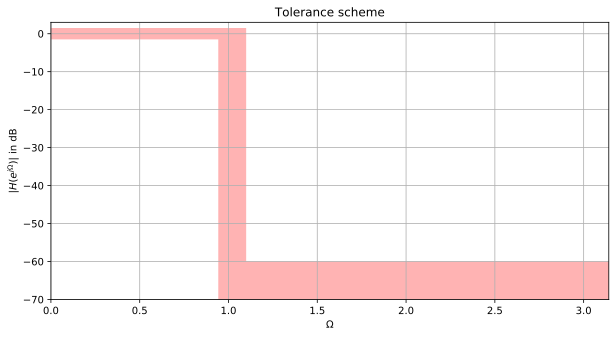

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.signal as sig
%matplotlib inline


def plot_tolerance_scheme(Omp, Oms, d_p, a_s):
    Omp = Omp * np.pi
    Oms = Oms * np.pi

    p = [[0, -d_p], [Omp, -d_p], [Omp, -300], [np.pi, -300],
         [np.pi, a_s], [Oms, a_s], [Oms, d_p], [0, d_p]]
    polygon = mpatches.Polygon(p, closed=True, facecolor='r', alpha=0.3)
    plt.gca().add_patch(polygon)


Omp = .3  # normalized corner frequency of pass-band
Oms = .3 + 0.05  # normalized corner frequency of stop-band
d_p = 1.5  # one-sided pass-band ripple in dB
a_s = -60  # stop-band attenuation in dB

plt.figure(figsize=(10, 5))
plot_tolerance_scheme(Omp, Oms, d_p, a_s)
plt.title('Tolerance scheme')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.axis([0, np.pi, -70, 3])
plt.grid()

**Exercise**

* What corner frequencies $f_\text{p}$ and $f_\text{s}$ result for a sampling frequency of $f_\text{s} = 48$ kHz?

Solution: It follows that $f_\text{p} = \frac{\Omega_\text{p}}{\pi}  \cdot \frac{f_\text{s}}{2} = 8$ kHz and $f_\text{s} = \frac{\Omega_\text{s}}{\pi}  \cdot \frac{f_\text{s}}{2} \approx 8.4$ kHz, since the normalized frequency $\Omega = \pi$ corresponds to $\frac{f_\text{s}}{2}$.

The comparison of non-recursive and recursive filters depends heavily on the chosen filter design algorithm. For the design of the non-recursive filter a technique is used which bases on numerical optimization of the filter coefficients with respect to the desired response. The [Remez algorithm](https://en.wikipedia.org/wiki/Remez_algorithm), as implemented in `scipy.signal.remez`, is used for this purpose. The parameters for the algorithm are the corner frequencies of the pass- and stop-band, as well as the desired attenuation in the stop-band. For the recursive filter, a [Chebyshev type II](https://en.wikipedia.org/wiki/Chebyshev_filter) design is used. Here the parameters are the corner frequency and attenuation of the stop-band. The order of both filters has been chosen manually to fit the given tolerance scheme.

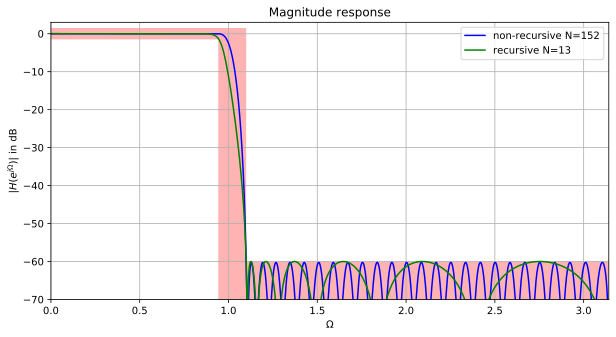

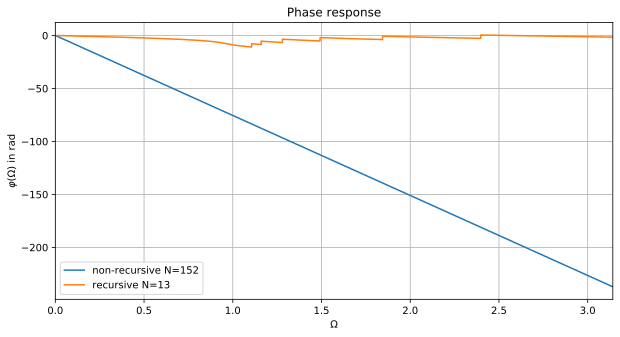

In [2]:
N = 152  # length of non-recursive filter
M = 13  # order of recursive filter

# design of non-recursive filter
h = sig.remez(N, [0, Omp/2, Oms/2, 1/2], [1, 10**((a_s-5)/20)], weight=[1, 1])

# design of recursive filter
b, a = sig.cheby2(M, -a_s, Oms)

# compute frequency response of filter
Om, Hn = sig.freqz(h, worN=8192)
Om, Hr = sig.freqz(b, a, worN=8192)

# plot frequency response
plt.figure(figsize=(10, 5))
plt.plot(Om, 20*np.log10(np.abs(Hn)), 'b-', label=r'non-recursive N=%d' % N)
plt.plot(Om, 20*np.log10(np.abs(Hr)), 'g-', label=r'recursive N=%d' % M)
plot_tolerance_scheme(Omp, Oms, d_p, a_s)
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend()
plt.axis([0, np.pi, -70, 3])
plt.grid()
# plot phase
plt.figure(figsize=(10, 5))
plt.plot(Om, np.unwrap(np.angle(Hn)), label=r'non-recursive N=%d' % N)
plt.plot(Om, np.unwrap(np.angle(Hr)), label=r'recursive N=%d' % M)
plt.title('Phase response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi(\Omega)$ in rad')
plt.legend(loc=3)
plt.xlim([0, np.pi])
plt.grid()

**Exercises**

* How do both designs differ in terms of their magnitude and phase responses?
* Calculate the number of multiplications and additions required to realize the non-recursive filter
* Calculate the number of multiplications and additions required to realize the recursive filter in [transposed direct form II](../recursive_filters/direct_forms.ipynb#Transposed-Direct-Form-II)
* Decrease the corner frequencies and adapt the order of the filters to match the tolerance scheme

Solution: Inspection of the magnitude response $|H(e^{j \Omega})|$ for the designed non-recursive and recursive filters reveals that both fulfill the given tolerance scheme. An obvious difference between both filters is the structure of the magnitude response in the stop-band $\Omega > \Omega_\text{s}$. While the magnitude of the non-recursive filter shows a high number of fluctuations below the desired attenuation, these are much less for the recursive filter. This is a consequence of the different orders of the filters and their respective number of zeros. The non-recursive filter requires $N$ multiplications and $N-1$ additions to compute one output sample, hence 152 multiplications and 151 additions. The recursive filter in transposed direct form II is realized by 7 SOS. Each of the SOS requires 5 multiplications and 4 additions per output sample, resulting in a total of 35 multiplications and 28 additions.

In order to evaluate the computational complexity of both filters, the execution time is measured when filtering a signal $x[k]$ of length $L=10^5$ samples. The non-recursive filter is realized by direct convolution, the recursive filter in transposed direct form II using the respective Python functions. 

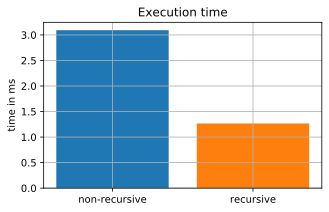

In [3]:
import timeit

reps = 1000  # number of repetitions for timeit

# setup environment for timeit
tsetup = 'import numpy as np; import scipy.signal as sig; from __main__ import h, a, b; x=np.random.normal(size=int(1e5))'
# non-recursive filter
tn = timeit.timeit('np.convolve(x, h, mode="full")', setup=tsetup, number=reps)
# recursive filter
tr = timeit.timeit('sig.lfilter(b, a, x)', setup=tsetup, number=reps)

# show the results
plt.figure(figsize=(5, 3))
plt.bar(1, tn/reps*1000)
plt.bar(2, tr/reps*1000)
plt.title('Execution time')
plt.xticks([1, 2], ('non-recursive', 'recursive'))
plt.ylabel('time in ms')
plt.grid()

**Exercises**

* Do the execution times correspond with the number of algorithmic operations calculated in the previous exercise?
* Estimate the computational load for the filtering of a signal with a sampling rate of 48 kHz
* How could the execution time of the non-recursive filter be decreased?
* Finally, would you prefer the non-recursive or the recursive design for a practical implementation? Consider the numerical complexity, as well as numerical aspects in your decision.

Solution: On general purpose processors, the numerical complexity is mainly determined by the number of multiplications. The ratio of multiplications per output sample for the non-recursive and the recursive filter is given as $\frac{152}{35} \approx 4.3$, the ratio of execution times in above example as $\frac{4.8 \mathrm{ ms}}{1.5 \mathrm{ ms}} \approx 3.2$. The difference between both can be related to the implementation of both methods and their execution on the given hardware. Note that the execution times and their ratio may differ for other environments. The number of samples used in the measurement above relates to a signal with $\frac{10^5}{f_s} \approx 2$ seconds length. The computational load for the non-recursive filter can hence be estimated as $\frac{4.8 \mathrm{ ms}}{2000 \mathrm{ ms}} \approx 2.4 \cdot 10^{-6}$. The execution time for the non-recursive filter may be decreased by using a fast convolution algorithm.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.